In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
pid = 202
qid = 7963
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

173377


173416

In [3]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

173377


1508

In [4]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(171869, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1,For improved exploitation of the energy conten...,Proof of concept for a new energy-positive was...,advanced primary treatment; carbon footprint; ...,"[Engineering, Environmental; Environmental Sci...",0,0
1,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
2,21,In the endeavour of avoiding presence of biode...,Mechanical-biological treatment: Performance a...,MBT; LCA; Waste composition; Biological treatm...,[Environmental Sciences],0,0
3,23,This paper evaluates the impact of changing we...,Factors Affecting the Frequency and Severity o...,None,"[Engineering, Civil; Transportation; Transport...",0,0
4,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0


In [8]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
            
        for c in Category.objects.filter(project=p):
            if DocCat.objects.filter(doc=d,category=c).exists():
                r[c.name]=1
            else:
                r[c.name]=0
        r_docs.append(r)
    
cat_cols = [c.name for c in Category.objects.filter(project=p)]
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"] + cat_cols]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(1349, 12)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,Indigenous involvement,Community participation,Risk assessment,Policy/proposed measures,Concrete adaptation evaluation,seen
0,75,This article applies a systems engineering app...,Requirements and Functional Analysis of a Mult...,hazard; vulnerability; multi-hazard; disaster ...,[Biodiversity Conservation; Environmental Scie...,1,0,0,0,0,0,1
1,5325,Increasing globalization has promoted the spre...,Historical environmental change in Africa driv...,approximate Bayesian computation; arbovirus; d...,[Biochemistry & Molecular Biology; Ecology; Ev...,0,0,0,0,0,0,1
2,5465,The merits of daily and monthly downscaling mo...,On the choice of the temporal aggregation leve...,None,[Meteorology & Atmospheric Sciences],1,0,0,0,0,0,1
3,9744,Within the commitment of the International Mar...,EEDI analysis of Ro-Pax and passenger ships in...,None,[Transportation],0,0,0,0,0,0,1
4,11017,India is considerably vulnerable in the events...,Local perceptions of and responses to climate ...,Climate change; Community perceptions; Vulnera...,[Environmental Sciences; Environmental Studies],1,0,0,0,0,1,1


In [11]:
df = pd.concat([seen_df,unseen_df],sort=True).sample(frac=1).reset_index(drop=True).fillna(0)
y = df['relevant']
df.head()

,Community participation,Concrete adaptation evaluation,Indigenous involvement,Policy/proposed measures,Risk assessment,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc
0,0.0,0.0,0.0,0.0,0.0,"Over the coming decades, the projected land-us...",1833117,0,0,Impacts of climate and land-use changes on flo...,climate change; land-use change; floods; Queen...,"[Geosciences, Multidisciplinary; Meteorology &..."
1,0.0,0.0,0.0,0.0,0.0,CO2 emissions from international aviation are ...,408932,0,0,Carbon dioxide emissions from international av...,CO2 emissions; long-term scenarios; internatio...,[Transportation]
2,0.0,0.0,0.0,0.0,0.0,The 'Flexible Plug and Play Low Carbon Network...,1793283,0,0,"The Design, Manufacture and Operation of a 33k...",0,"[ENGINEERING, ELECTRICAL & ELECTRONIC]"
3,0.0,0.0,0.0,0.0,0.0,The objective of this study is to determine th...,820379,0,0,Simulating the effects of climate change and a...,Wind power; Climate change; Afforestation; Reg...,[Green & Sustainable Science & Technology; Ene...
4,0.0,0.0,0.0,0.0,0.0,"In broiler houses, ventilation removes moistur...",518683,0,0,Field study on effects of a heat exchanger on ...,broiler performance; CO(2) emission; energy us...,"[Agriculture, Dairy & Animal Science]"


In [12]:
duplicateRowsDF = df[df.duplicated(['title','content'])]
print(duplicateRowsDF.shape)

duplicateRowsDF.head()



(13, 12)


,Community participation,Concrete adaptation evaluation,Indigenous involvement,Policy/proposed measures,Risk assessment,content,id,relevant,seen,title,wosarticle__de,wosarticle__wc
44662,0.0,0.0,0.0,0.0,0.0,"In the context of climate change, there is pot...",283674,0,0,Natural Disaster Occurrence and Average Global...,Climate change; emergency events database; lin...,"[Geosciences, Multidisciplinary; Meteorology &..."
56017,0.0,0.0,0.0,0.0,0.0,In compliance with the EU Flood Directive to r...,1843600,0,0,Flood risk management in Flanders: from flood ...,0,"[Engineering, Environmental; Engineering, Civi..."
96871,0.0,0.0,0.0,0.0,0.0,"In recent years, environmental issues such as ...",797537,0,0,Influence of Heat Collection Plate Structure o...,exhaust heat; heat recovery; continuous castin...,[Metallurgy & Metallurgical Engineering]
108229,0.0,0.0,0.0,0.0,0.0,Global warming has contributed to a greater fr...,520517,0,0,"CLIMATE CHANGE, AGRICULTURAL INSURANCE AND GOV...",climate change; drought; agricultural insuranc...,[Metallurgy & Metallurgical Engineering]
116525,0.0,0.0,0.0,0.0,0.0,This paper presents a comprehensive and consis...,1816073,0,0,Incremental costs of carbon storage in forestr...,terrestrial carbon sinks; carbon storage costs...,[Environmental Sciences]


In [13]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


Int64Index([    66,     85,    134,    188,    236,    571,    635,    732,
               892,   1023,
            ...
            172402, 172427, 172522, 172724, 172821, 172953, 172957, 172995,
            173058, 173114],
           dtype='int64', length=1349)
Int64Index([159485,   5454,  59381,  24382, 101886,  74861, 101182, 102737,
             19321,  21239,
            ...
            123914, 151632,  58510,  29799,  90797, 126366,  27943,  61315,
            150280,  26818],
           dtype='int64', length=1080)


(0.0, 1087.16)

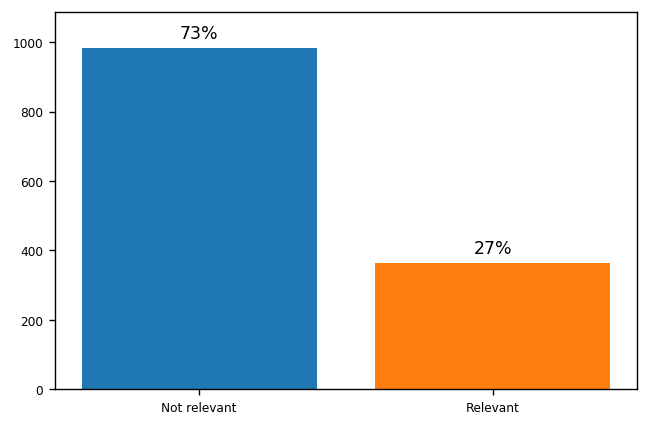

In [33]:
fig, ax = plt.subplots(dpi=125)
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")
    
ax.set_xticks([0,1])
ax.set_xticklabels(["Not relevant","Relevant"])
    
ax.set_ylim(ymax=ax.get_ylim()[1]+n*0.04)

In [15]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=20, max_df=0.6, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
ab_X = vec.fit_transform(df['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


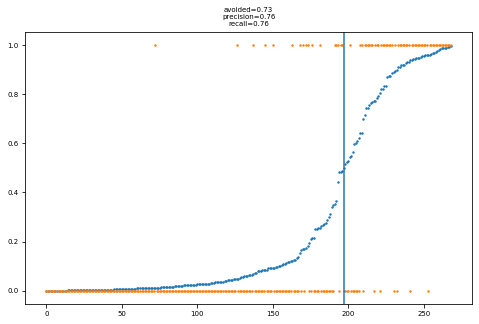

In [16]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots(figsize=(8,5))
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

In [17]:
from sklearn.model_selection import KFold

model = {}
model['p'] = []
model['r'] = []
model['e'] = []
model['i'] = []

kf = KFold(n_splits=5)

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    clf = MultinomialNB(alpha=0.1)
    clf.fit(ab_X[k_train],y[k_train])
    predictions = clf.predict(ab_X[k_test])
    model['e'].append(clf.score(ab_X[k_test],y[k_test]))
    # Precision
    model['p'].append(precision_score(predictions,y[k_test]))
    # Recall
    model['r'].append(recall_score(predictions,y[k_test]))
    #print(k_train)
    

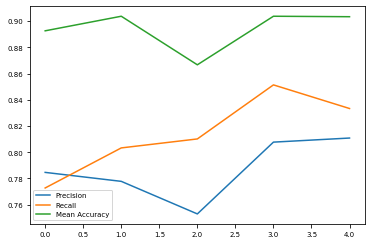

In [18]:
fig, ax = plt.subplots()
ax.plot(model['p'],label="Precision")
ax.plot(model['r'],label="Recall")
ax.plot(model['e'],label="Mean Accuracy")

plt.legend()

plt.show()

In [19]:
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    for model in models:
        clf = model['model']
        model['i'].append(i)
        #clf = SVC(kernel='rbf',probability=True)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        # Precision
        model['p'].append(precision_score(predictions,y[k_test]))
        # Recall
        model['r'].append(recall_score(predictions,y[k_test]))

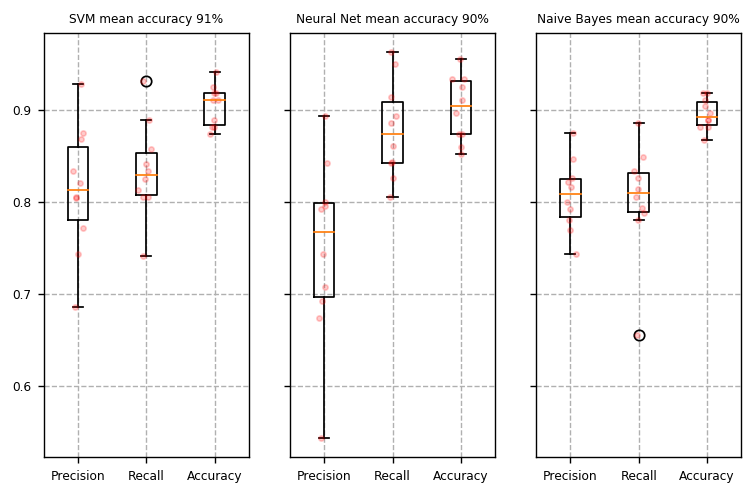

In [21]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    ax = axs[i]
    ax.boxplot([model['p'],model['r'], model['e']])
    
    for i,s in enumerate(['p','r','e']):
        py = model[s]
        x = np.random.normal(i+1, 0.04, size=len(py))
        ax.plot(x, py, 'r.', alpha=0.2)
    
    ax.set_xticklabels(['Precision', 'Recall','Accuracy'])
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    
    
plt.show()

In [28]:
y = df['relevant']
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [29]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

44516
171869


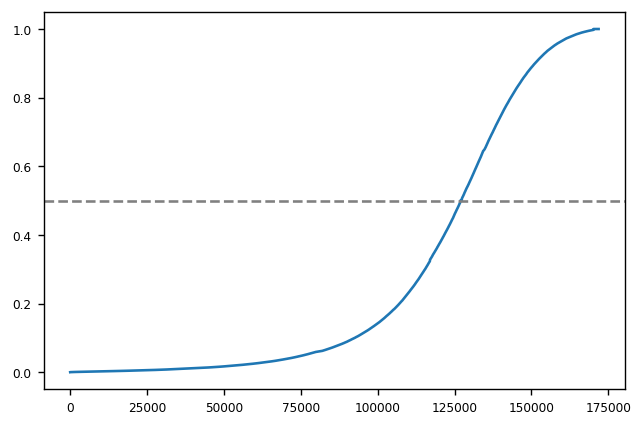

In [31]:
plt.close()

fig, ax = plt.subplots(dpi=125)

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

In [35]:
q, created = Query.objects.get_or_create(
    title="predicted relevant",
    text="Manually created",
    creator=User.objects.get(last_name="Sietsma"),
    project=q.project
)
q.users.all()

<QuerySet []>

In [37]:
pr_ids = pdf[(pdf['prediction'] > 0.5)]['id']
len(pr_ids)

44516

In [38]:
Through = Doc.query.through
dqs = [Through(doc_id=d,query=q) for d in pr_ids]
Through.objects.bulk_create(dqs)

q.r_count = q.doc_set.count()
q.save()

In [40]:
pr_ids = pdf[(pdf['relevant'] ==1)]['id']
len(pr_ids)

dqs = [Through(doc_id=d,query=q) for d in pr_ids]
Through.objects.bulk_create(dqs)

q.r_count = q.doc_set.count()
q.save()

In [43]:
now=datetime.datetime.now()
df[['id','prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)